In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error #, accuracy_score ,f1_score,confusion_matrix, classification_report
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor

#========================================================== Helper Functions ========================================================================

def remove_value(data, column_name, string_to_replace, replace_value='', change_dataType=True):
  data[column_name] = data[column_name].str.replace(string_to_replace, replace_value)
  if change_dataType:
    data[column_name] = data[column_name].astype(int)
    # data[column_name].value_counts()

def Feature_Encoder(X, cols):
    encoders = {}
    for c in cols:
        lbl = LabelEncoder()
        lbl.fit(list(X[c].values))
        X[c] = lbl.transform(list(X[c].values))
        encoders[c] = lbl
    return X, encoders

def featureScaling(X, a, b):
    X = np.array(X)
    Normalized_X = np.zeros((X.shape[0], X.shape[1]))
    for i in range(X.shape[1]):
        Normalized_X[:, i] = ((X[:, i] - min(X[:, i])) / (max(X[:, i]) - min(X[:, i]))) * (b - a) + a
    return Normalized_X

def execute_model(model, X_train, Y_train, X_test, Y_test, model_name):
    model.fit(X_train, Y_train)
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    train_mse = mean_squared_error(Y_train, Y_train_pred)
    print(f"{model_name}:\n Training MSE: {train_mse}")

    test_mse = mean_squared_error(Y_test, Y_test_pred)
    print(f" Testing MSE: {test_mse}")

    draw(Y_test, Y_test_pred, model_name)

def draw(Y_test, Y_test_pred, model_name):

    plt.figure
    plt.subplot(2,1,1)
    plt.scatter(range(len(Y_test)), Y_test, color='blue', label='Actual')

    plt.subplot(2,1,2)
    plt.scatter(range(len(Y_test_pred)), Y_test_pred, color='red', label=model_name)

    plt.xlabel('Data Points')
    plt.ylabel('Target Variable')
    plt.title('Regression Model Predictions')
    plt.legend()
    plt.show()


#========================================================== Read Data ========================================================================

data = pd.read_csv('ElecDeviceRatingPrediction.csv')
# print(data.head())


In [2]:

#========================================================= Preprocessing ========================================================================

# Null Values
print(data.isna().sum())

# processor_gnrtn
data['processor_gnrtn'].value_counts()
mode_value = data['processor_gnrtn'].mode()[0]
data['processor_gnrtn'].replace('Not Available', mode_value, inplace = True)
remove_value(data, 'processor_gnrtn', 'th')

# ram_gb
remove_value(data,'ram_gb' ,' GB')

# ssd
remove_value(data,'ssd' ,' GB')

# hdd
remove_value(data,'hdd' ,' GB')

# os
data[['os_bits', 'os_type']] = data['os'].str.split(' ', expand=True)
data = data.drop('os', axis = 1)
print('os_bits', ":", data['os_bits'].unique())
print('os_type', ":", data['os_type'].unique())
remove_value(data,'os_bits' ,'-bit')

# graphic_card_gb
remove_value(data,'graphic_card_gb' ,' GB')

# warranty
remove_value(data,'warranty' ,'No warranty', '0', False)
remove_value(data,'warranty' ,' years', '', False)
remove_value(data,'warranty' ,' year')

# Touchscreen
remove_value(data,'Touchscreen' ,'No', '0', False)
remove_value(data,'Touchscreen' ,'Yes', '1')

# msoffice
remove_value(data,'msoffice' ,'No', '0', False)
remove_value(data,'msoffice' ,'Yes', '1')

# rating
remove_value(data,'rating' ,' stars', '', False)
remove_value(data,'rating' ,' star')

# ram_type
ram_performance_mapping = {
    'LPDDR4X': 5,
    'LPDDR4': 4,
    'DDR4': 3,
    'DDR3': 2,
    'DDR5': 6,
    'LPDDR3': 1
}

data['ram_type'] = data['ram_type'].map(ram_performance_mapping)
# data['ram_type'].value_counts()

# weight
weight = {
    'Casual':2,
    'ThinNlight':1,
    'Gaming':3,
}
data['weight'] = data['weight'].map(weight)

# brand , processor_name
encode_cols = ('brand', 'processor_name')
data, encoders = Feature_Encoder(data, encode_cols)

one_hot_encoders = {}
# processor_brand
one_hot_encoded = pd.get_dummies(data['processor_brand'])
one_hot_encoded = one_hot_encoded.astype(int)
one_hot_encoders['processor_brand'] = one_hot_encoded


data = data.drop('processor_brand', axis = 1)
data = pd.concat([data, one_hot_encoded], axis=1)

# os_type
one_hot_encoded = pd.get_dummies(data['os_type'])
one_hot_encoded = one_hot_encoded.astype(int)
one_hot_encoders['os_type'] = one_hot_encoded

data = data.drop('os_type', axis = 1)
data = pd.concat([data, one_hot_encoded], axis=1)

# Replace target column
rating_col = data['rating']
data = data.drop('rating', axis = 1)
data = pd.concat([data, rating_col], axis=1)



brand                0
processor_brand      0
processor_name       0
processor_gnrtn      0
ram_gb               0
ram_type             0
ssd                  0
hdd                  0
os                   0
graphic_card_gb      0
weight               0
warranty             0
Touchscreen          0
msoffice             0
Price                0
rating               0
Number of Ratings    0
Number of Reviews    0
dtype: int64
os_bits : ['64-bit' '32-bit']
os_type : ['Windows' 'DOS' 'Mac']


<Axes: >

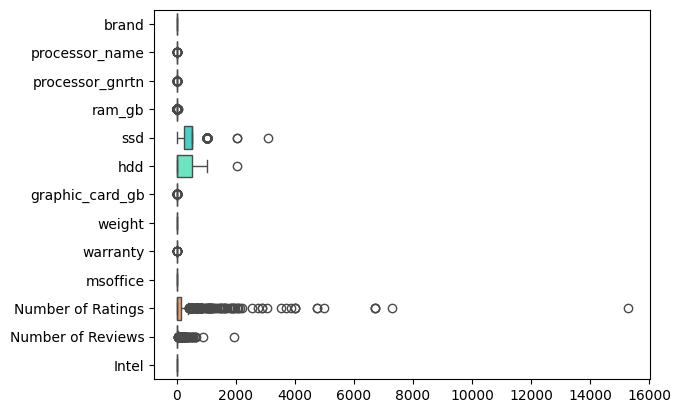

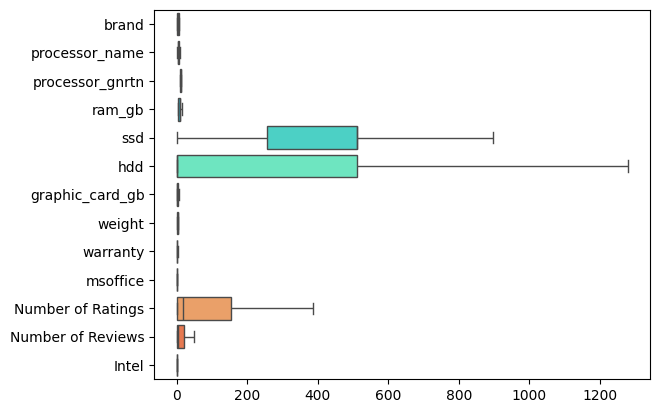

In [3]:
#================================================================ Outliers =======================================================================

columns_to_exclude = ['ram_type', 'Touchscreen', 'os_bits', 'AMD', 'M1', 'DOS', 'Mac', 'Windows', 'rating','Price']
data_filtered = data.drop(columns=columns_to_exclude)

# Create the box plot with the modified data
sns.boxplot(data=data_filtered, palette='rainbow', orient='h')

Q1 = data.iloc[:,:-1].quantile(0.25)
Q3 = data.iloc[:,:-1].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

s = ['ram_type' ,'Touchscreen', 'os_bits' , 'AMD' , 'M1' , 'DOS' , 'Mac' , 'Windows' ]

# Replace the outliers with lower_bound or upper_bound values
for col in data.iloc[:,:-1]:
    if col not in s:
        data.loc[data[col] < lower_bound[col], col] = lower_bound[col]
        data.loc[data[col] > upper_bound[col], col] = upper_bound[col]

# sns.boxplot(data=data,palette='rainbow',orient='h')
data_filtered = data.drop(columns=columns_to_exclude)

plt.figure()
# Create the box plot with the modified data
sns.boxplot(data=data_filtered, palette='rainbow', orient='h')




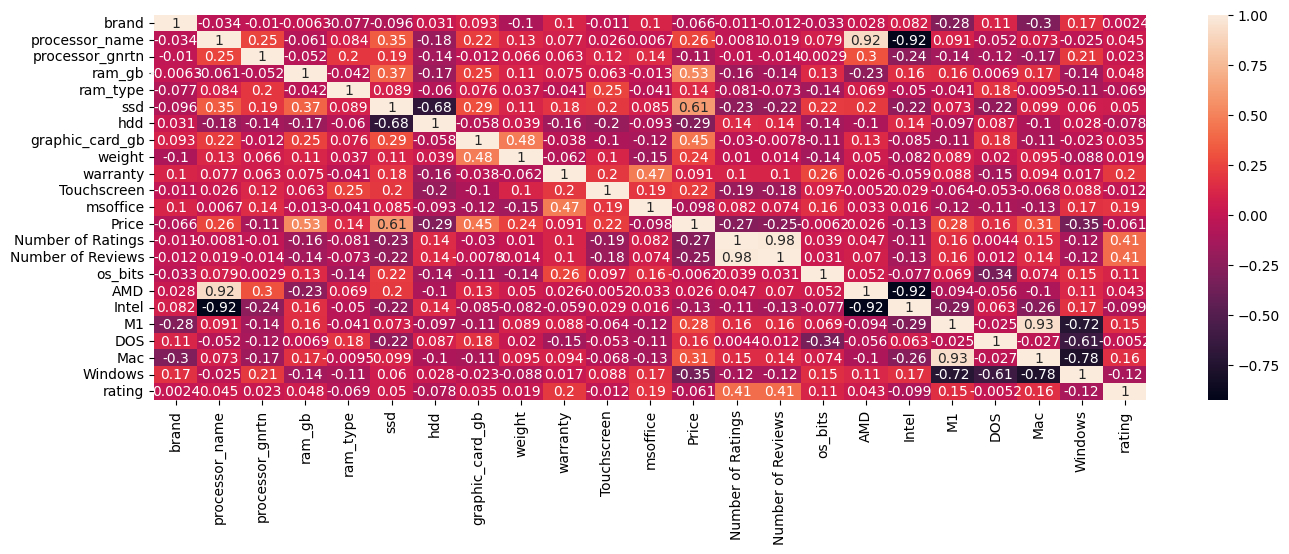

rating               1.000000
Number of Reviews    0.411103
Number of Ratings    0.409994
warranty             0.203488
msoffice             0.185427
Mac                  0.160914
M1                   0.152030
os_bits              0.105672
ssd                  0.049794
ram_gb               0.048108
processor_name       0.044920
AMD                  0.042674
graphic_card_gb      0.035395
processor_gnrtn      0.023220
weight               0.018774
brand                0.002407
DOS                 -0.005155
Touchscreen         -0.011999
Price               -0.060844
ram_type            -0.068767
hdd                 -0.078448
Intel               -0.099465
Windows             -0.124356
Name: rating, dtype: float64
Top features:  Index(['warranty', 'msoffice', 'Number of Ratings', 'Number of Reviews',
       'os_bits', 'M1', 'Mac', 'Windows', 'rating'],
      dtype='object')
Features after preprocessing:

brand : [1 5 4 0 3 7 6 2] int64
processor_name : [6.  2.  0.  1.  9.  5.  8.  3.  7.  9

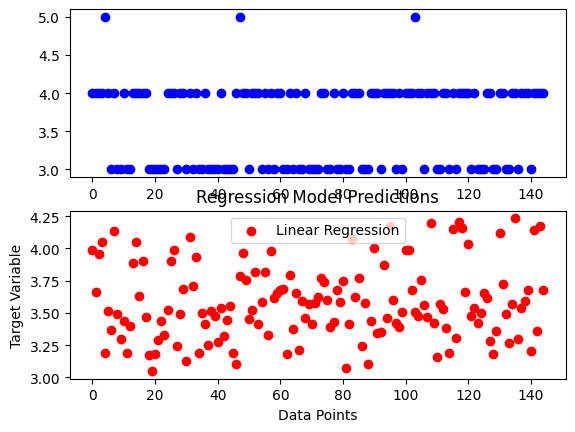

Polynomial Regression:
 Training MSE: 0.1601368094132745
 Testing MSE: 0.3828608363743687


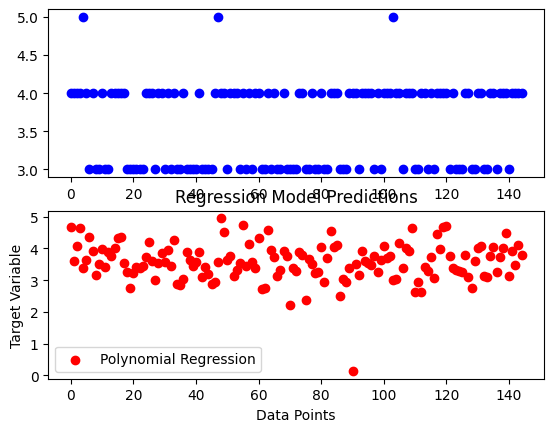

Decision Tree:
 Training MSE: 0.0
 Testing MSE: 0.23448275862068965


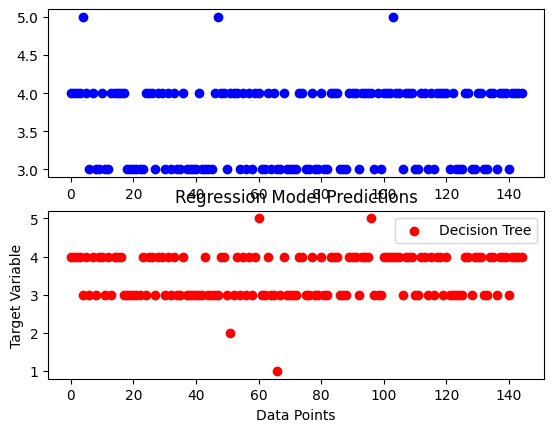

In [4]:
# ========================================================== Feature selection =========================================================================

corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(16,5))
sns.heatmap(corr_matrix, annot=True)
plt.show()

print(corr_matrix["rating"].sort_values(ascending=False))

top_feature = corr_matrix.index[abs(corr_matrix['rating']) > 0.1]
print("Top features: ", top_feature)

#==================================================================================================================================================

print("Features after preprocessing:\n")
for col in data.columns:
  if(col == "Price" or col == "Number of Ratings" or col == "Number of Reviews"):
    continue
  print(col, ":", data[col].unique(), data[col].dtype)

# ========================================================== Regression Models ================================================================

# Split Data
X = data.iloc[:, :-1]
Y = data['rating']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=70)

# plt.figure
# plt.subplot(2,1,1)
# plt.scatter(range(len(Y)), Y, color='blue', label='Actual')

# ========================== Linear Regression ==================================

linear_regression_model = linear_model.LinearRegression()
execute_model(linear_regression_model, X_train, Y_train, X_test, Y_test, "Linear Regression")

# ======================= Polynomial Regression =================================

poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

poly_model = linear_model.LinearRegression()
execute_model(poly_model, X_train_poly, Y_train, X_test_poly, Y_test, "Polynomial Regression")

# ========================== Decision Tree =======================================

decision_tree_reg = DecisionTreeRegressor()
execute_model(decision_tree_reg, X_train, Y_train, X_test, Y_test, "Decision Tree")

# Saving the Model


In [5]:
import pickle

In [6]:
model = linear_model.LinearRegression()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=70)

In [7]:
model.fit(X_train, Y_train)

LinearRegression()

In [8]:
filename = 'MS1 test script regression.sav'
pickle.dump(model, open(filename, 'wb'))

# Saving label encoder

In [9]:
pickle.dump(encoders, open("ms1 regression encoders.sav", 'wb'))

# Saving one hot encoder

In [10]:
pickle.dump(one_hot_encoders, open("ms1 regression one hot encoders.sav", 'wb'))